# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import math
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import heapq
from typing import *
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Definitions

In [2]:
class GeoUtility:
    def get_intersect_in_dual(point_a, point_b):
        value = linalg.solve(np.array([point_a, point_b]), np.ones(2))
        return np.array([round(value[0], 5), round(value[1], 5)])

    def sort_points_by_polar(points):
        keys = points.keys()
        return sorted(keys, key=lambda x: np.arctan(x[1] / x[0]))

    def normalize_vector(vector: tuple):
        return np.array(vector) / sum(vector)

    def max_skew_given_median(q, median):
        direction = np.dot(linalg.inv(np.dot(q.T, q)), median) # Direction of max skew
        return direction / sum(direction) # Unit vector

    def is_in_between(query_vector, start_vector, end_vector):
        return np.arctan(start_vector[1] / start_vector[0]) < np.arctan(query_vector[1] / query_vector[0]) < np.arctan(end_vector[1] / end_vector[0])

In [3]:
'''
Linked list of intersect points of a line
'''
class LinkedList:
    def __init__(self, point, neighbours, line, next=None):
        self.point = point # Intersect point
        self.next = next
        self.neighbours = neighbours # Other linked lists, for the lines, lying on this intersect
        self.line = line

    def append_to_end(start, l):
        cur = start
        while cur.next is not None:
            cur = cur.next
        cur.next = l

    def __str__(self):
        return f"value: {self.point} --> {self.next is None}"

In [4]:
class MedianRegion:
    def __init__(self, start: LinkedList, end: LinkedList, median: tuple):
        self.start = start
        self.end = end
        self.median = median # The median point inside the original points list, not the projected one!

    def __str__(self):
        return f"start: {self.start.point}, end: {self.end.point}, median: {self.median}"

In [5]:
class SD:
    def __init__(self, points, mean):
        self.points = points
        self.n = len(points)
        self.mean = mean
        self.sum = sum(points)
        self.x_2_sum = sum([p[0]**2 for p in points])
        self.y_2_sum = sum([p[1]**2 for p in points])
        self.xy_sum = sum([p[0]*p[1] for p in points])

    def get_sd(self, f):
        mean_f = np.dot(self.mean, f)
        sd2 = self.n * mean_f**2 - 2 * mean_f * np.dot(self.sum, f) + f[0]**2 * self.x_2_sum + f[1]**2 * self.y_2_sum + 2 * f[0] * f[1] * self.xy_sum
        return math.sqrt(sd2 / self.n)

In [6]:
class MaxSkewCalculator:
    def __init__(self, points: 'pd.DataFrame', heap, vector_transfer, epsilon):
        points[0] = points[0] - points[0].min()
        points[1] = points[1] - points[1].min()
        self.points = np.array(points)
        self.q = self.points - np.mean(self.points, axis=0)
        self.intersects = {} # {intersect --> [points]}
        self.intersect_keys = [] # sorted list of intersect points
        self.line_intersects = {} # {line --> [LinkedList[intersect]]}
        self.sd = SD(self.points, np.mean(self.points, axis=0))
        self.heap = heap
        self.vector_transfer = vector_transfer
        self.epsilon = epsilon

    def get_angel(self, vec1, vec2):
        vec1 = vec1 / np.linalg.norm(vec1)
        vec2 = vec2 / np.linalg.norm(vec2)
        return np.arccos(np.clip(np.dot(vec1, vec2), -1.0, 1.0))

    def _get_first_median_on_x(self):
        x_sorted = sorted(self.points, key=lambda x: x[0])
        return tuple(x_sorted[len(self.points) // 2])

    def _calc_skew(self, f, median, verbose=False):
        m_point = np.array(median)
        mean_f = np.dot(self.sd.mean, f)

        if verbose:
            print(np.median(np.dot(self.points, f)), np.dot(m_point, f))
            p_f_1 = np.dot(self.points, f)
            mean_1 = np.mean(p_f_1)
            sd_1 = np.std(p_f_1)
            median_1 = np.median(p_f_1)
            skew_1 = (mean_1 - median_1) / sd_1

        skew = abs((mean_f - np.dot(m_point, f)) / self.sd.get_sd(f))

        if verbose:
            if round(skew, 3) != round(abs(skew_1), 3):
                print(f"Error: {skew}, {skew_1}")

        return skew

    def _get_next_median(self, intersection, candidate_points, prev_median):
        candidate_points = sorted(candidate_points, key=lambda x: np.arctan(x[1] / x[0]))
        index = candidate_points.index(prev_median)
        return candidate_points[len(candidate_points) - index - 1]

    def _get_intersects(self):
        self.intersects = {}
        for i in range(len(self.points) - 1):
            point_a = self.points[i]
            for point_b in self.points[i + 1:]:
                try:
                    point_a, point_b = tuple(point_a), tuple(point_b)
                    intr = tuple(GeoUtility.get_intersect_in_dual(point_a, point_b))
                    if intr in self.intersects:
                        self.intersects[intr].add(point_a)
                        self.intersects[intr].add(point_b)
                    else:
                        self.intersects[intr] = set([point_a, point_b])
                except:
                    continue
        self.intersect_keys = GeoUtility.sort_points_by_polar(self.intersects)
        # Keep intersection in the upper halfspace
        self.intersect_keys = list(filter(lambda x: x[1] > 0 and x[0] > 0, self.intersect_keys))

    def _get_line_intersects(self):
        self.line_intersects = {}

        for key in self.intersect_keys:
            intersect = key
            occurs = self.intersects[intersect]

            links = [LinkedList(intersect, [], point, None) for point in occurs]
            for link in links:
                link.neighbours = links

            for i, point in enumerate(occurs):
                if point in self.line_intersects:
                    l = self.line_intersects[point]
                    LinkedList.append_to_end(l, links[i])
                else:
                    self.line_intersects[point] = links[i]

    def preprocess(self):
        self._get_intersects()
        self._get_line_intersects()
        print(f"Number of intersects: {len(self.intersects)}")

    def train(self, verbose=False):
        first_median = self._get_first_median_on_x()
        last_vec = None
        # Main Loop
        finish = False
        median_region = MedianRegion(LinkedList((1 / first_median[0], 0), [], first_median, None), self.line_intersects[first_median], first_median)
        while not finish:
            if verbose:
                print(median_region)
            skew_vector_start = GeoUtility.normalize_vector(median_region.start.point)
            # skew_vector_end = normalize_vector(median_region.end)
            # skew_vector_max = max_universal_skew(self.q, mean - median_region.median)
            # if lies_between(skew_vector_max, skew_vector_start, skew_vector_end):
                # heapq.heappush(skew_heap, (-calc_skew(skew_vector_max, median_region.median, sd), tuple(skew_vector_max)))
            if last_vec is not None and self.get_angel(skew_vector_start, last_vec) > self.epsilon:
                heapq.heappush(self.heap, (-self._calc_skew(skew_vector_start, median_region.median, verbose), self.vector_transfer(tuple(skew_vector_start))))
                last_vec = skew_vector_start
            if last_vec is None:
                last_vec = skew_vector_start
            # heapq.heappush(skew_heap, (calc_skew(points, skew_vector_end, mean, median_region.median), tuple(skew_vector_end)))

            if median_region.end.point[0] == 0:
                print("Reached Y axis, finish.")
                break # Reached the Y axis!

            # Next median region
            try:
                current_points = self.intersects[median_region.end.point]
            except:
                print("Didn't find end of median region, quit.")
                break

            line_b = self._get_next_median(median_region.end.point, current_points, median_region.median)
            next_neighbour = list(filter(lambda n: n.line == line_b, median_region.end.neighbours))[0]

            if verbose:
                print(f"nextneighbour: {next_neighbour.point}, next: {next_neighbour.next}")

            if next_neighbour.next is None:
                new_end = LinkedList((0, 1 / line_b[1]), [], line_b, None)
            else:
                new_end = next_neighbour.next # change of line

            median_region = MedianRegion(median_region.end, new_end, line_b) # median changes to line_b!

    def get_high_skews(self, top_k=10):
        count = 0
        heap = self.heap.copy()
        while True:
            count = count + 1
            try:
                yield heapq.heappop(heap)
                if count == top_k:
                    break
            except:
                break

    def get_tail_accuracy(self, f, model):
        pass

# Run

## Load DataSet

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
%cd /content

/content


In [8]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d currie32/crimes-in-chicago

Dataset URL: https://www.kaggle.com/datasets/currie32/crimes-in-chicago
License(s): unknown
crimes-in-chicago.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip crimes-in-chicago.zip

Archive:  crimes-in-chicago.zip
replace Chicago_Crimes_2001_to_2004.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
data = pd.read_csv("Chicago_Crimes_2012_to_2017.csv")
# data = data.sample(frac=0.1, random_state=1)
data.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


## Pre-Process

In [12]:
data.shape

(1456714, 23)

In [13]:
data = data.dropna()
# data = data.sample(frac=0.1, random_state=1)

In [14]:
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop(['ID'], axis=1)
data = data.drop(['Case Number'], axis=1)

In [15]:
data['date2'] = pd.to_datetime(data['Date'])
data['Year'] = data['date2'].dt.year
data['Month'] = data['date2'].dt.month
data['Day'] = data['date2'].dt.day
data['Hour'] = data['date2'].dt.hour
data['Minute'] = data['date2'].dt.minute
data['Second'] = data['date2'].dt.second
data = data.drop(['Date'], axis=1)
data = data.drop(['date2'], axis=1)
data = data.drop(['Updated On'], axis=1)
data.head()

<ipython-input-15-1e4451272971>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date2'] = pd.to_datetime(data['Date'])


,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
0,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,...,1893681.0,2016,41.864073,-87.706819,"(41.864073157, -87.706818608)",5,3,23,40,0
1,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,...,1864330.0,2016,41.782922,-87.604363,"(41.782921527, -87.60436317)",5,3,21,40,0
2,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,...,1904819.0,2016,41.894908,-87.758372,"(41.894908283, -87.758371958)",5,3,23,31,0
3,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15.0,28.0,...,1901475.0,2016,41.885687,-87.749516,"(41.885686845, -87.749515983)",5,3,22,10,0
4,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15.0,28.0,...,1901675.0,2016,41.886297,-87.761751,"(41.886297242, -87.761750709)",5,3,22,0,0


In [16]:
data['Block'] = pd.factorize(data["Block"])[0]
data['IUCR'] = pd.factorize(data["IUCR"])[0]
data['Description'] = pd.factorize(data["Description"])[0]
data['Location Description'] = pd.factorize(data["Location Description"])[0]
data['FBI Code'] = pd.factorize(data["FBI Code"])[0]
data['Location'] = pd.factorize(data["Location"])[0]
data["Primary Type"] = pd.factorize(data["Primary Type"])[0]

In [17]:
# Remove outliar
data = data[data["Latitude"] > 40]

In [18]:
long, lat = data["Longitude"], data["Latitude"]
data["Longitude"] = (long - long.min()) / (long.max() - long.min())
data["Latitude"] = (lat - lat.min()) / (lat.max() - lat.min())

<ipython-input-18-40e6abe60260>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Longitude"] = (long - long.min()) / (long.max() - long.min())


## Visualize

In [20]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon

sample_data = data.sample(frac=0.01, random_state=1)

chicri_geometry = [Point(xy) for xy in zip(sample_data["Longitude"], sample_data["Latitude"])]
chicri_points = GeoDataFrame(sample_data, geometry=chicri_geometry)

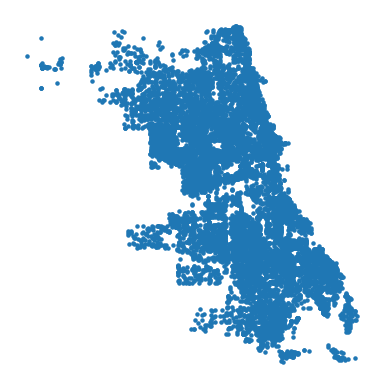

In [21]:
chicri_points_map = chicri_points.plot(markersize=5)
chicri_points_map.set_axis_off()

## Load & Evaluate Classification Model

In [19]:
final_df = data.sample(n=500, random_state=1)
features = ["Month", "Hour", "Latitude", "Longitude", "Primary Type", "IUCR", "FBI Code"]
X_train = final_df[features]
y_train = final_df["Arrest"]
final_df["Lat"] = final_df["Latitude"]
final_df["Lon"] = final_df["Longitude"]
final_df["Target"] = final_df["Arrest"]
data["Lat"] = data["Latitude"]
data["Lon"] = data["Longitude"]
data["Target"] = data["Arrest"]

In [20]:
final_df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,Longitude,Location,Month,Day,Hour,Minute,Second,Lat,Lon,Target
1404081,23954,6,2,6,0,False,False,1232,12.0,25.0,...,0.680777,146569,11,4,2,50,0,0.573994,0.680777,False
329531,7539,195,14,183,29,True,False,1022,10.0,24.0,...,0.555442,159428,10,1,21,25,0,0.569983,0.555442,True
840771,5067,2,0,2,2,False,False,1031,10.0,22.0,...,0.509784,192026,6,28,12,20,0,0.528017,0.509784,False
59726,5620,38,14,36,3,True,False,531,5.0,9.0,...,0.764475,12980,2,22,22,50,0,0.126396,0.764475,True
945934,704,31,11,29,1,False,False,1133,11.0,24.0,...,0.537613,17832,11,7,8,0,0,0.600838,0.537613,False


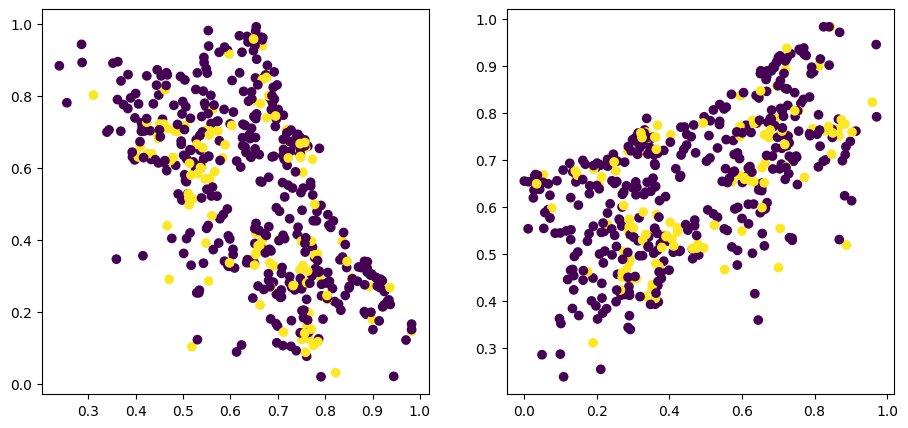

In [21]:
x_train_new = np.array(final_df[["Lon", "Lat"]])
y_train_new = np.array(final_df["Target"])

max_y = np.max(x_train_new[:, 1])
x_train_new_prime = np.array(list(map(lambda row: [max_y - row[1] , row[0]], x_train_new)))

fig, axis = plt.subplots(1, 2, figsize=(11, 5))
axis[0].scatter(x=x_train_new[:, 0], y=x_train_new[:, 1], c=final_df["Target"])
axis[1].scatter(x=x_train_new_prime[:, 0], y=x_train_new_prime[:, 1], c=final_df["Target"])

In [22]:
x_train_new.shape, y_train_new.shape, final_df.shape, data.shape

((500, 2), (500,), (500, 26), (1418291, 26))

In [23]:
%cd /content/drive/My Drive/Colab Notebooks/UnknownSensAttr

/content/drive/My Drive/Colab Notebooks/UnknownSensAttr


In [24]:
target = "Arrest"

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from joblib import dump, load

clf = MLPClassifier(random_state=1)

# Load
clf = load('Model_MLP_1.0_v0.1.joblib')
# clf = load('Model_MLP_0.1.joblib')
# clf = DecisionTreeClassifier(random_state=1)

# Train
# clf.fit(data[features], data[target])


y_pred_train = clf.predict(data[features])
print(f"Accuracy on train: {accuracy_score(data[target], y_pred_train)}")
print(f"F1: {f1_score(data[target], y_pred_train)}")

Accuracy on train: 0.8742493606742199
F1: 0.724941433751124


## Main Loop

In [26]:
import time


start = time.time()
points = pd.DataFrame(x_train_new)
points_prime = pd.DataFrame(x_train_new_prime)

skew_heap = []
max_skew_1 = MaxSkewCalculator(points, skew_heap, lambda x: tuple([x[0], x[1]]), math.pi / 10)
max_skew_2 = MaxSkewCalculator(points_prime, skew_heap, lambda x: tuple([-x[1], x[0]]), math.pi / 10)

max_skew_1.preprocess()
max_skew_2.preprocess()

max_skew_1.train()
max_skew_2.train()

end = time.time()
print(f"time: {start - end}")

Number of intersects: 123627
Number of intersects: 123703
Reached Y axis, finish.
Reached Y axis, finish.
time: -26.867114067077637


<ipython-input-6-d078d65cb130>:45: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_points = sorted(candidate_points, key=lambda x: np.arctan(x[1] / x[0]))


In [27]:
list(max_skew_2.get_high_skews(top_k=10))

[(-0.2057857645622841, (-0.253825600170482, 0.7461743998295179)),
 (-0.1619308425287817, (-0.4278736688994582, 0.5721263311005417)),
 (-0.14185970857286812, (0.22581697514030413, 0.7741830248596959)),
 (-0.09411194677570671, (0.40874448088232596, 0.5912555191176739)),
 (-0.07986596218205724, (0.57255443033453, 0.42744556966547)),
 (-0.03192991856204457, (-0.5910234054677024, 0.4089765945322976)),
 (-0.007646595996045566, (-0.777762657083927, 0.2222373429160731)),
 (-0.007107322001367157, (0.7479935094392295, 0.2520064905607705))]

In [29]:
from matplotlib.lines import Line2D

(0.0, 0.9709225377656687)

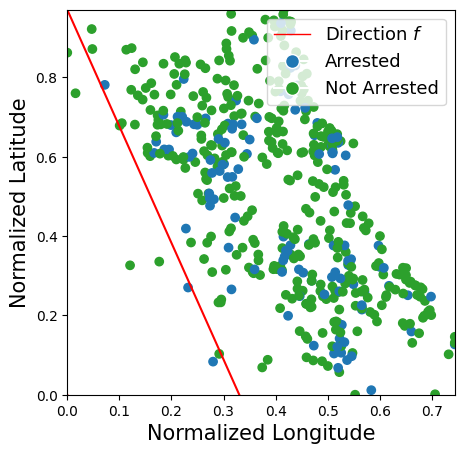

In [75]:
fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(points)
xmin, xmax = np.min(points_np[:, 0]), np.max(points_np[:, 0])
ymin, ymax = np.min(points_np[:, 1]), np.max(points_np[:, 1])
label = y_train_new
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=["#1f77b4" if x==1 else "#2ca02c" for x in label])
x = np.arange(xmin, 2 * xmax)
f = (-0.253825600170482, 0.7461743998295179)
f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")
# plt.xlim(min(xmin, ymin), max(xmax, ymax))
# plt.ylim(min(ymin, xmin), max(ymax, xmax))
plt.xlabel("Normalized Longitude", fontsize=15)
plt.ylabel("Normalized Latitude", fontsize=15)

line = Line2D([0], [0], label='Direction $f$', color='red', linewidth=1)
b = Line2D([0], [0], marker='o', color='w', label='Arrested', markerfacecolor='#1f77b4', markersize=10)
b2 = Line2D([0], [0], marker='o', color='w', label='Not Arrested', markerfacecolor='#2ca02c', markersize=10)
ax.legend(handles=[line, b, b2], fontsize=13, loc="upper right")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

In [76]:
f = np.array(f)
p_f = np.dot(points, f)
mean = np.mean(p_f)
sd = np.std(p_f)
median = np.median(p_f)
sk = (mean - median) / sd
sk

-0.20578706871512661

### Get Tail


In [77]:
# df = final_df.copy(deep=True)
# df = df[["Lon", "Lat"]]
# df["Lat"] = final_df["Lat"] - final_df["Lat"].min()
# df["Lon"] = final_df["Lon"] - final_df["Lon"].min()

df = data.copy(deep=True)
df = df[["Lon", "Lat"]]
df["Lat"] = data["Lat"] - data["Lat"].min()
df["Lon"] = data["Lon"] - data["Lon"].min()

(14134, 26) (1418291, 2)


Text(0, 0.5, 'Normalized Latitude')

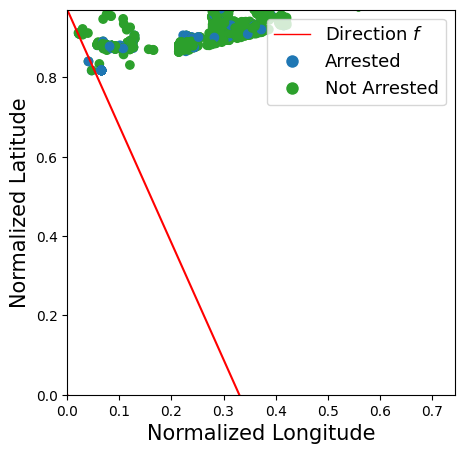

In [83]:
q = 0.01
# q = 0.125

q1 = np.quantile(np.dot(df[["Lon", "Lat"]], f), q if -sk < 0 else (1 - q))
tail = data[df.apply(lambda x: np.dot((x[0], x[1]), f) < q1 if -sk < 0 else np.dot((x[0], x[1]), f) > q1, axis=1)]
# tail["Lat"] = tail["Lat"] - tail["Lat"].min()
# tail["Lon"] = tail["Lon"] - tail["Lon"].min()
print(tail.shape, df.shape)

tail = tail.sample(frac=0.1)

fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(tail[["Lon", "Lat"]])
# xmin, xmax = np.min(points_np[:, 0]), np.max(points_np[:, 0])
# ymin, ymax = np.min(points_np[:, 1]), np.max(points_np[:, 1])
label = tail["Target"]
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=["#1f77b4" if x==1 else "#2ca02c" for x in label])
x = np.arange(xmin, 2 * xmax)
f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")
# plt.xlim(min(xmin, ymin), max(xmax, ymax))
# plt.ylim(min(ymin, xmin), max(ymax, xmax))

line = Line2D([0], [0], label='Direction $f$', color='red', linewidth=1)
b = Line2D([0], [0], marker='o', color='w', label='Arrested', markerfacecolor='#1f77b4', markersize=10)
b2 = Line2D([0], [0], marker='o', color='w', label='Not Arrested', markerfacecolor='#2ca02c', markersize=10)
ax.legend(handles=[line, b, b2], fontsize=13, loc="upper right")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel("Normalized Longitude", fontsize=15)
plt.ylabel("Normalized Latitude", fontsize=15)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

data_sample_train = tail[features]
data_sample_target = tail["Target"]

y_pred_train = clf.predict(np.array(data_sample_train))
print(f"Accuracy on train: {accuracy_score(data_sample_target, y_pred_train)}")
print(f"F1: {f1_score(data_sample_target, y_pred_train)}")

Accuracy on train: 0.9225352112676056
F1: 0.4210526315789474


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


## Synthesize Dataset

(502, 3) (502,)


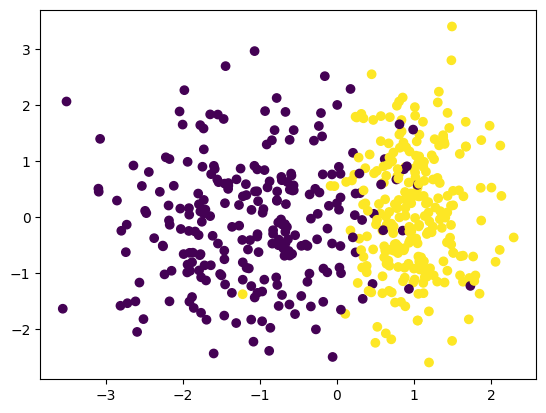

In [ ]:
# Synthesize Data
NUM_SAMPLES = 502
data = make_classification(n_samples=NUM_SAMPLES, n_features=3, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1)
print(data[0].shape, data[1].shape)
plt.scatter(x=data[0][:, 0], y=data[0][:, 1], c=data[1]);

Accuracy on Test: 0.9411764705882353, accuracy on train: 0.9356984478935698


Text(0.5, 0, '$x_1$')

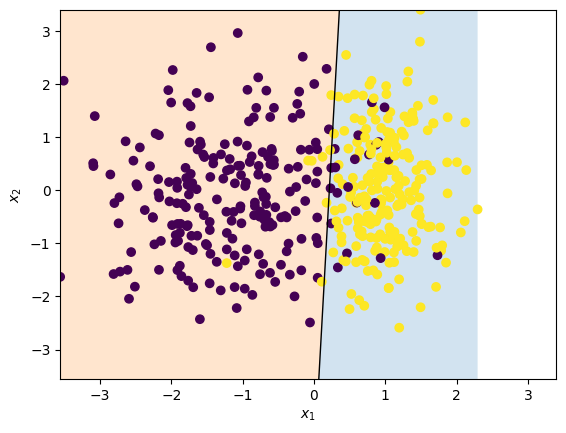

In [ ]:
# Just first two columns
data_x = np.delete(data[0], 2, axis=1)
# Train classifier
x_train, x_test, y_train, y_test = train_test_split(data[0] if data[0].shape[0] == 2 else data_x, data[1], test_size=.1)
classifier = LogisticRegression(verbose=1)
classifier.fit(x_train, y_train)
y_pred_test = classifier.predict(x_test)
y_pred_train = classifier.predict(x_train)
print(f"Accuracy on Test: {accuracy_score(y_test ,y_pred_test)}, accuracy on train: {accuracy_score(y_train ,y_pred_train)}")
# Plot decision boundary
b = classifier.intercept_[0]
w1, w2 = classifier.coef_.T
c = -b/w2
m = -w1/w2
xmin, xmax = np.min(x_train[:, 0]), np.max(x_train[:, 0])
ymin, ymax = np.min(x_train[:, 1]), np.max(x_train[:, 1])
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='-')
plt.fill_between(xd, yd, min(ymin, xmin), alpha=0.2)
plt.fill_between(xd, yd, max(ymax, xmax), alpha=0.2)

# plt.scatter(*X[Y==0].T, s=8, alpha=0.5)
# plt.scatter(*X[Y==1].T, s=8, alpha=0.5)
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train)
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(ymin, xmin), max(ymax, xmax))
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

In [ ]:
# Remove a demographic group
FEMALE_NUM = 20

N = len(x_train)
x_train_male = x_train[y_train == 1]
x_train_female = x_train[y_train == 0]
np.random.shuffle(x_train_female)
x_train_new = np.concatenate((x_train_male, x_train_female[:FEMALE_NUM]), axis=0)
y_train_new = np.array([1 for _ in range(len(x_train_male))] + [0 for _ in range(FEMALE_NUM)])
x_train_new.shape, y_train_new.shape

((244, 2), (244,))

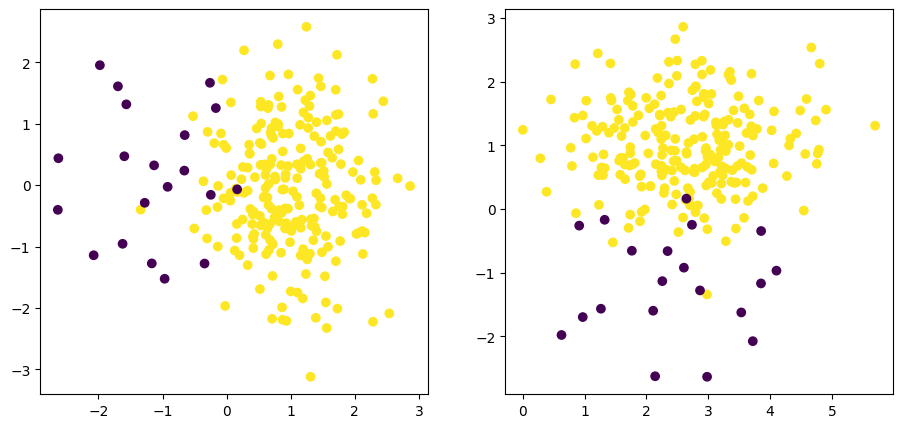

In [ ]:
# Make two instances of data to support both first and second quarter of R^2
max_y = np.max(x_train_new[:, 1])
x_train_new_prime = np.array(list(map(lambda row: [max_y - row[1] , row[0]], x_train_new)))

fig, axis = plt.subplots(1, 2, figsize=(11, 5))
axis[0].scatter(x=x_train_new[:, 0], y=x_train_new[:, 1], c=y_train_new)
axis[1].scatter(x=x_train_new_prime[:, 0], y=x_train_new_prime[:, 1], c=y_train_new)

## Load Dataset [Income]

In [ ]:
!pip install -q kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d goldenoakresearch/us-household-income-stats-geo-locations

 89% 2.00M/2.24M [00:00<00:00, 2.92MB/s]
100% 2.24M/2.24M [00:00<00:00, 2.79MB/s]


In [ ]:
!unzip us-household-income-stats-geo-locations.zip

Archive:  us-household-income-stats-geo-locations.zip
  inflating: Income_Methodology.pdf  
  inflating: Kaggle_deffs.pdf        
  inflating: kaggle_income.csv       


In [ ]:
data = pd.read_csv("kaggle_income.csv", encoding="ISO-8859-1")
data = data.dropna()
print(data.shape)
data.head()

(32526, 19)


,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638.260513
1,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,place,36048,334,26070325,23254,31.708516,-85.611039,37725,19528,43789,258.017685
2,1011020,1,Alabama,AL,Shelby County,Columbiana,Columbiana city,City,place,35051,205,44835274,261034,33.191452,-86.615618,54606,31930,57348,926.031000
3,1011030,1,Alabama,AL,Mobile County,Satsuma,Creola city,City,place,36572,251,36878729,2374530,30.874343,-88.009442,63919,52814,47707,378.114619
4,1011040,1,Alabama,AL,Mobile County,Dauphin Island,Dauphin Island,Town,place,36528,251,16204185,413605152,30.250913,-88.171268,77948,67225,54270,282.320328


In [ ]:
data = data.drop(["id", "Median", "Stdev", "sum_w"], axis=1)
encodes = ["State_Name", "State_ab", "County", "City", "Place", "Type", "Primary", "Zip_Code"]
for enc in encodes:
    data[enc] = LabelEncoder().fit_transform(data[enc])
data.head()

,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean
0,1,0,1,650,1250,495,2,1,5586,251,10894952,909156,30.771450,-88.079697,38773
1,1,0,1,63,4125,540,2,1,5486,334,26070325,23254,31.708516,-85.611039,37725
2,1,0,1,922,1453,569,2,1,5324,205,44835274,261034,33.191452,-86.615618,54606
3,1,0,1,650,6431,618,2,1,5574,251,36878729,2374530,30.874343,-88.009442,63919
4,1,0,1,650,1709,660,6,1,5557,251,16204185,413605152,30.250913,-88.171268,77948


In [ ]:
# bins = pd.IntervalIndex.from_tuples([(-300, 45000), (45000, 60000), (60000, 70000), (70000, 250000)])
bins = pd.IntervalIndex.from_tuples([(-300, 60000), (60000, 250000)])
data["Target"] = pd.cut(data["Mean"], bins=bins)
data["Target"] = LabelEncoder().fit_transform(data["Target"])
# final_df = data[["Lat", "Lon", "Target"]]
# final_df.head()
data.head()

,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Target
0,1,0,1,650,1250,495,2,1,5586,251,10894952,909156,30.771450,-88.079697,38773,0
1,1,0,1,63,4125,540,2,1,5486,334,26070325,23254,31.708516,-85.611039,37725,0
2,1,0,1,922,1453,569,2,1,5324,205,44835274,261034,33.191452,-86.615618,54606,0
3,1,0,1,650,6431,618,2,1,5574,251,36878729,2374530,30.874343,-88.009442,63919,1
4,1,0,1,650,1709,660,6,1,5557,251,16204185,413605152,30.250913,-88.171268,77948,1


In [ ]:
data["Target"].value_counts()

1    16600
0    15926
Name: Target, dtype: int64

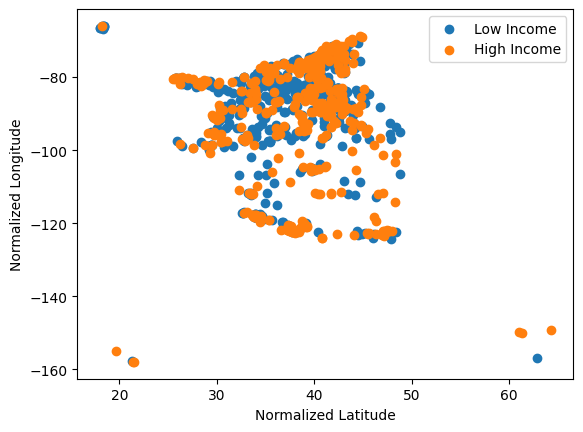

In [ ]:
data_sample = data.sample(frac=0.03, random_state=1)
final_df = data_sample[["Lat", "Lon", "Target"]]
plt.scatter(x=final_df[final_df["Target"] == 0]["Lat"], y=final_df[final_df["Target"] == 0]["Lon"])
plt.scatter(x=final_df[final_df["Target"] == 1]["Lat"], y=final_df[final_df["Target"] == 1]["Lon"])
plt.legend(labels=["Low Income", "High Income"])
plt.xlabel("Normalized Latitude")
plt.ylabel("Normalized Longitude")
plt.show()

<ipython-input-17-397b8990cc52>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Lat"] = final_df["Lat"] - final_df["Lat"].min()
<ipython-input-17-397b8990cc52>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Lon"] = final_df["Lon"] - final_df["Lon"].min()


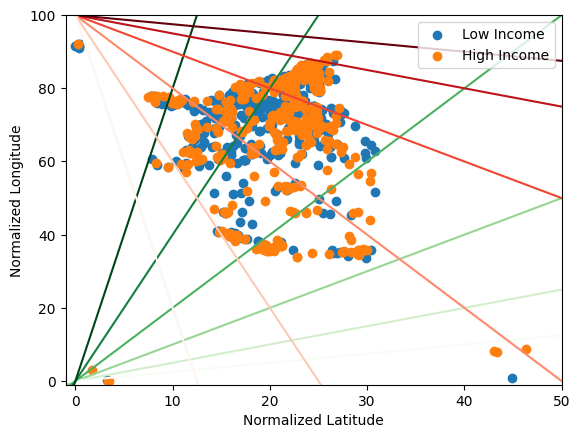

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.colors as mcolors

spl = mpl.colormaps['Greens'].resampled(6)
spl = [mcolors.rgb2hex(spl(i)) for i in range(spl.N)]

spl2 = mpl.colormaps['Reds'].resampled(6)
spl2 = [mcolors.rgb2hex(spl2(i)) for i in range(spl2.N)]

# To Be Removed
data_sample = data.sample(frac=0.03, random_state=1)
final_df = data_sample[["Lat", "Lon", "Target"]]
final_df["Lat"] = final_df["Lat"] - final_df["Lat"].min()
final_df["Lon"] = final_df["Lon"] - final_df["Lon"].min()
plt.scatter(x=final_df[final_df["Target"] == 0]["Lat"], y=final_df[final_df["Target"] == 0]["Lon"])
plt.scatter(x=final_df[final_df["Target"] == 1]["Lat"], y=final_df[final_df["Target"] == 1]["Lon"])

# x = np.arange(-10, 80)
# f = 1, 1 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y, color=spl[2])

# f = 1, 1/2 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y, color=spl[1])

# f = 1, 1/4 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y, color=spl[0])

# f = 1, 2 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y, color=spl[3])

# f = 1, 4 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y, color=spl[4])

# f = 1, 8 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y, color=spl[5])


# x = np.arange(-10, 80)
# f = 1, -1 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y + 100, color=spl2[3])

# f = 1, -1/2 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y + 100, color=spl2[4])

# f = 1, -1/4 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y + 100, color=spl2[5])

# f = 1, -2 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y + 100, color=spl2[2])

# f = 1, -4 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y + 100, color=spl2[1])

# f = 1, -8 # ADD YOUR DIRECTION HERE
# f = f / linalg.norm(f)
# y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
# plt.plot(x, y + 100, color=spl2[0])


plt.xlim(-1, 50)
plt.ylim(-1, 100)
plt.legend(labels=["Low Income", "High Income"], loc="upper right")
plt.xlabel("Normalized Latitude")
plt.ylabel("Normalized Longitude")
plt.show()

In [ ]:
final_df.shape

(976, 3)

# Debug

In [ ]:
points = np.array([[19, 16],
       [ 7,  1],
       [18, 15],
       [11, 20],
       [ 1,  7],
       [15,  7],
       [ 9,  8],
       [ 1, 12],
       [ 1,  7],
       [11, 13],
       [17,  8],
       [ 5,  9],
       [20, 16],
       [14, 18],
       [20, 10]])

iterations = [
    (0.09090909090909091, 0),
    (0.05085, 0.0339),
    (0.0289, 0.08092),
    (0.02041, 0.08163),
    (0.00885, 0.10619),
    (0, 0.1111111111111111)
]



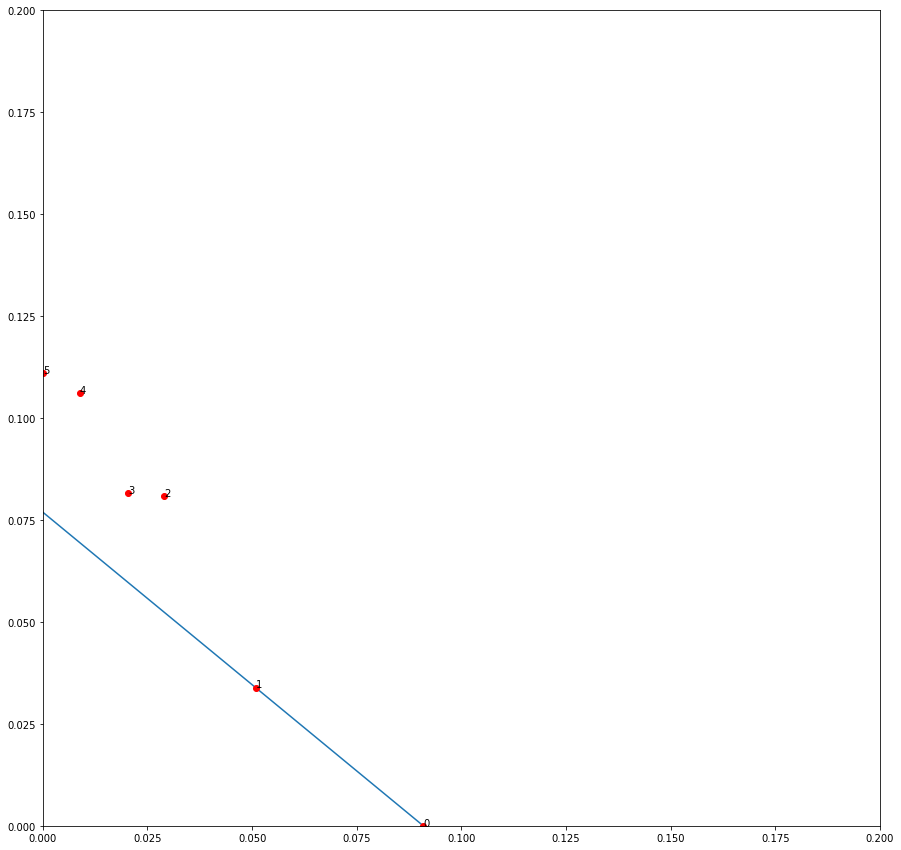

In [ ]:
max_y = 0
max_x = 0
fig, ax = plt.subplots(figsize=(15,15))

for point in points:
    x = 1 / point[0]
    y = 1 / point[1]
    if x > max_x:
        max_x = x
    if y > max_y:
        max_y = y
    ax.axline([x, 0], [0, y], c=next(ax._get_lines.prop_cycler)['color'])

for i, intr in enumerate(iterations):
    ax.plot(intr[0], intr[1], "ro")
    ax.annotate(i, (intr[0], intr[1]))

plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.show()

### Decision Boundary*

In [ ]:
f = np.array([1, - 1 / m[0]])
p_f = np.dot(points, f)
mean = np.mean(p_f)
sd = np.std(p_f)
median = np.median(p_f)
(mean - median) / sd

-0.2922669866776671

## Get Accuracy on F

12
Accuracy on train: 0.6666666666666666


(39.28910530360218, 435.97466336123495)

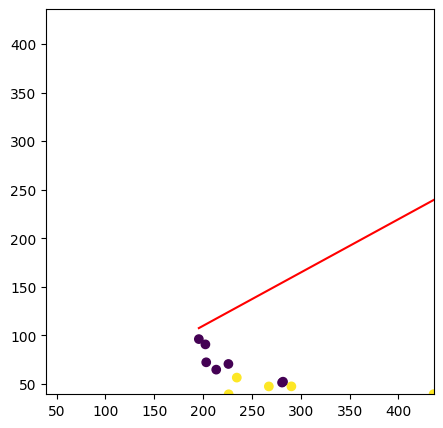

In [ ]:
p_f = np.dot(points, f)

if sk > 0:
    middle = 3 * (np.max(p_f) - np.min(p_f)) / 4
    middle = (np.max(p_f) - np.min(p_f)) / 2
    points_filtered = points[(p_f - np.min(p_f)) > middle]
    target = y_train_new[(p_f - np.min(p_f)) > middle]
    x = x_train_new[(p_f - np.min(p_f)) > middle]
else:
    middle = (np.max(p_f) - np.min(p_f)) / 4
    points_filtered = points[(p_f - np.min(p_f)) < middle]
    target = y_train_new[(p_f - np.min(p_f)) < middle]
    x = x_train_new[(p_f - np.min(p_f)) < middle]

y = classifier.predict(x)
print(len(points_filtered))
print(f"Accuracy on train: {accuracy_score(target, y)}")

fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(points_filtered)
xmin, xmax = np.min(points_np[:, 0]), np.max(points_np[:, 0])
ymin, ymax = np.min(points_np[:, 1]), np.max(points_np[:, 1])
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=target)
x = np.arange(xmin, 2 * xmax)

f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(ymin, xmin), max(ymax, xmax))